## Code to compute MLE for two parameters (Grid search) of coupled PHUs (with mobility matrix) using synthetic data and negative binomial noise

shape of M is (4, 2, 2, 2720)


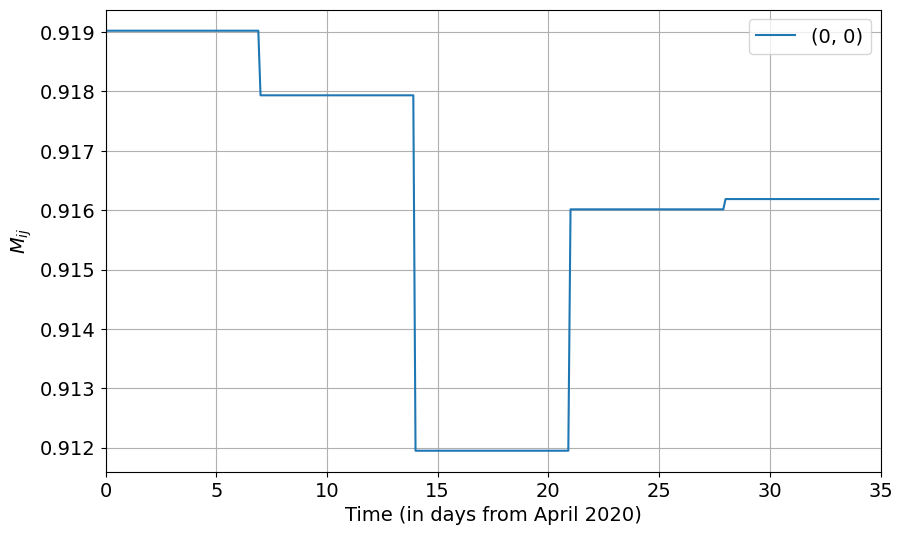

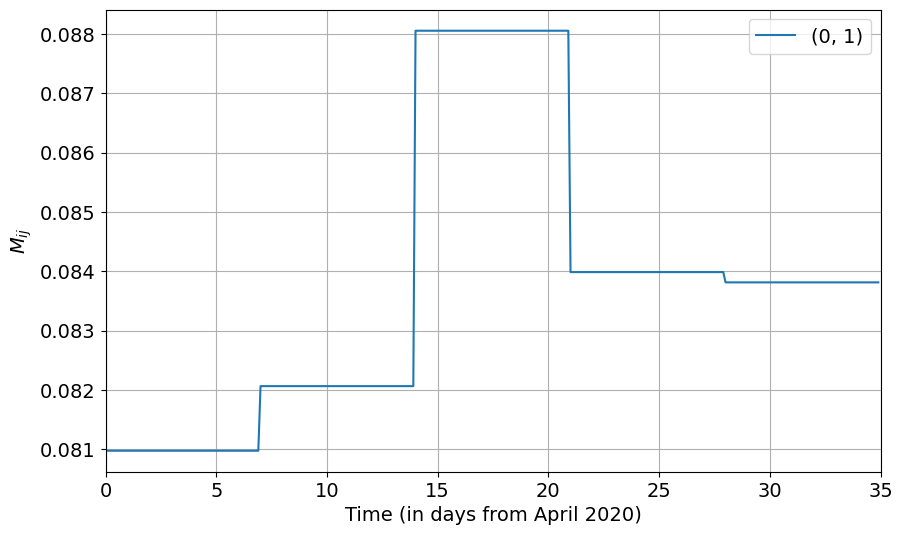

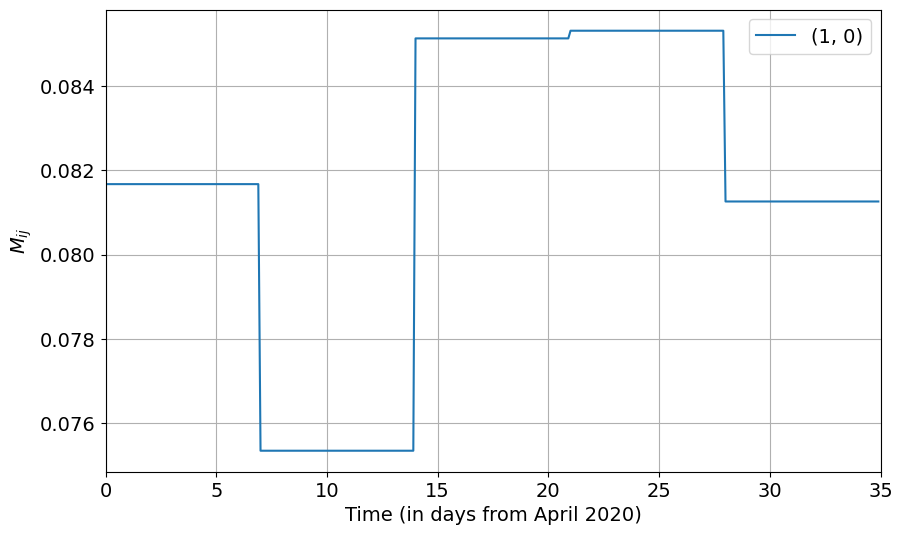

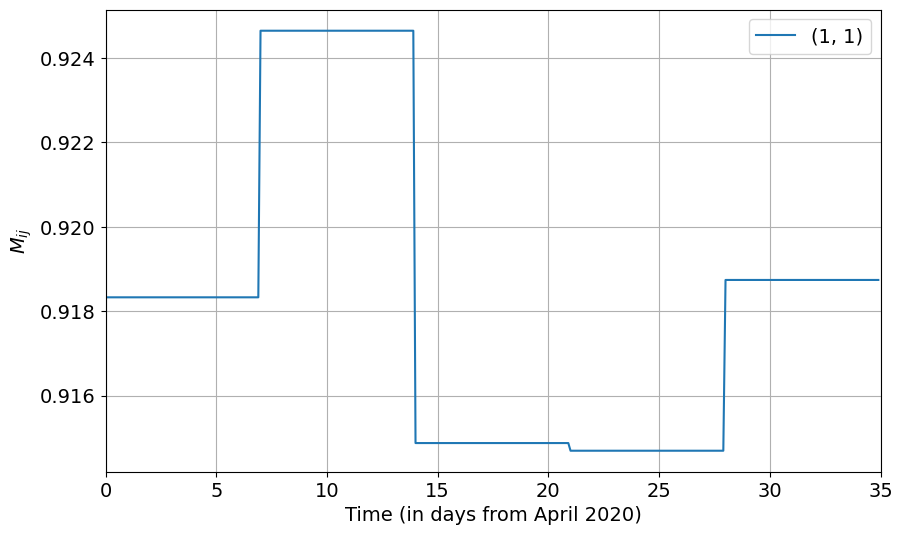

initial infected in PHU1 430.0
total population in PHU1 2794356.0
initial infected in PHU2  94.0
total population in PHU2  696992.0


In [1]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import math


##### CHANGE HERE #############
### Use the time up to which you need to estimate the two parameters of sigmoid from the coupled PHUs
dt = 0.1
tlim = 35
tstart = 20
t = np.arange(tstart, tlim, 1)


### keep starting at 0 
tmoh = np.arange(0, tlim, dt)

ndiv = 1/dt

### Number of coupled PHUs
N_city = 2

##### CHANGE HERE #############

###### If you have your own data, load it here #######
### Currently loaded infection data from MOH, for April 2020 to March 2021

PHU_path = './../../../PHU_Data/'
Mobility_path = './../../../mobility_tensor'
Data = np.zeros([365,4])

files = os.listdir(PHU_path)


target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/04-Durham.csv'
target_file3 = f'{PHU_path}/34-York.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')

population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')



# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


# For true model output
I_model = np.zeros((len(t),N_city))
# For noisy synthetic model output
I_synthetic = np.zeros((len(t),N_city))


# Stratification Tensor M
M = np.zeros((4,N_city,N_city,2720))

print("shape of M is", np.shape(M))

#####################################################################################


#  Below part of code uses the weekly data to generate the daily values 
# of mobility tensor and further saves it in each time step. 

## This part can also be simplified by accessing the required mobility inside the ode solving loop

# Load the Mobility tensor values based on the Flow matrix

# Week number 13 (starting from 0) is April 6th.
# Week number 37 is Sep 21st.

Mtensor = np.zeros([52,2,2])


directory_path = f'{Mobility_path}/stochastic_Tor_Durham'
filesmobility = os.listdir(directory_path)

for ii in range(52):
    
      target_name_part = "Stochastic_matrix"+str(ii)+".dat"
    
      for file in filesmobility:
            if target_name_part == file:
              target_file = file
              break
      else:
        raise FileNotFoundError(f"Could not find any file containing '{target_name_part}'.")

      Mtensor[ii,:,:] = np.genfromtxt(f'{directory_path}/{target_file}', delimiter=' ')


mrange = int((272-0)/7) + 1


for w in range(mrange):
   
    sw = 7*w
    
    if(w != mrange-1):
        tsw = np.linspace(sw, sw+6, int((1/dt)*6+1))
    else:
        tsw = np.linspace(sw, sw+5, int((1/dt)*5+1))

    
    # print("length of tsw is", len(tsw))
    for swk in range(len(tsw)):
        mindex = int((1/dt) * sw + swk)
        M[0,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        

    tsw2 = np.linspace(sw+6+dt, sw+7, int((1/dt)*1))
    for swk2 in range(1,len(tsw2)):
        mindex2 = mindex + swk2
        M[0,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]



### Plot mobilities 
mpl.rcParams.update({'font.size':14})
for i in range(N_city):
    for j in range(N_city):
        plt.figure(i+j,figsize=(10,6))
        plt.plot(tmoh, M[0,i,j,0:len(tmoh)], label=f'{i,j}')
        plt.legend(loc='best')
        plt.xlabel('Time (in days from April 2020)')
        plt.xlim([0,tlim])
        plt.ylabel('$M_{ij}$')
        plt.grid()
        plt.show()


#####################################################################################

#####Force of infection , Lambda
L_Force = np.zeros((len(tmoh),N_city))

 
total = np.zeros((N_city))


total[0] = population_by_phu[29,1]

total[1] = population_by_phu[3,1]


# Initial Conditions
 
E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
R[0,0] = 0
D[0,0] = 0
N[0,0] = total[0]
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]

E[0,1] = Data[0,1]
I[0,1] = Data[0,1]
R[0,1] = 0
D[0,1] = 0
N[0,1] = total[1]
S[0,1] = N[0,1] - E[0,1] - I[0,1] - R[0,1] - D[0,1]


I_model[0,0] = I[0,0]
I_model[0,1] = I[0,1]

I_synthetic[0,0] = I[0,0]
I_synthetic[0,1] = I[0,1]

# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

print("initial infected in PHU2 ",I[0,1])

print("total population in PHU2 ",total[1])

#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


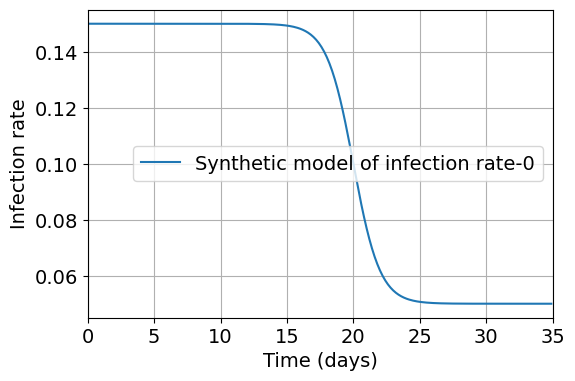

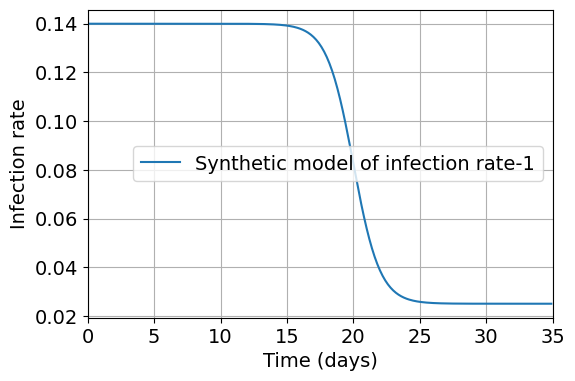

In [7]:

### UNCOMMNET THE RESPECTIVE PARAMETERS WHICH YOU ARE ESTIMATING

### FIRST INDEX REFERES TO THE PARAMETER AND SECOND INDEX TO THE PHU NUMBER
############ Model Parameters for generating Synthetic Data ####################

# original    
a01 =   0.15
a11 =  -0.1
t11 =  20
a21 =   0.05
t21 =  35
a31 =   -0.07
t31 = 60
a41 =  0.035
t41 = 80
a51 =  0.08
t51 = 140
a61 =  -0.065
t61 = 180
a71 =  0.025
t71 = 190
a81 =  -0.015
t81 = 230  

#### CHNAGE HERE ####
beta_i[:,0] = a01  + a11/(1 + np.exp((t11-tmoh))) 
# +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
beta_e[:,0] = beta_i[:,0]


################### Durham ##########################################################

# Original
a02 =   0.14
a12 =  -0.115
t12 =  20
a22 =   0.06
t22 =  35
a32 =   -0.05
t32 = 65
a42 =  0.035
t42 = 90
a52 =  0.06
t52 = 140
a62 =  -0.075
t62 = 180
a72 =  0.06
t72 = 190
a82 =  -0.025
t82 = 250


#### CHNAGE HERE ####
beta_i[:,1] = a02   + a12/(1 + np.exp((t12-tmoh))) 
# +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
beta_e[:,1] = beta_i[:,1]


################### York ##########################################################

# Original
# a0 =   0.12
# a1 =  -0.1
# t1 =  20
# a2 =   0.08
# t2 =  35
# a3 =   -0.04
# t3 = 50
# a4 =  0.07
# t4 = 130
# a5 = -0.04
# t5 = 200
# a6 =  0
# t6 = 180
# a7 =  0
# t7 = 230


# beta_i[:,2] = a0 + a1/(1 + np.exp((t1-t))) +  a2/(1 + np.exp((t2-t))) + a3/(1 + np.exp((t3-t))) + a4/(1 + np.exp((t4-t))) + a5/(1 + np.exp((t5-t)))  + a6/(1 + np.exp((t6-t)))  + a7/(1 + np.exp((t7-t))) 
# beta_e[:,2] = beta_i[:,2]


################### Peel ##########################################################

# original
# a0 =   0.15
# a1 =  -0.1
# t1 =  20
# a2 =   0.05
# t2 =  35
# a3 =   -0.07
# t3 = 60
# a4 =  0.035
# t4 = 80
# a5 =  0.08
# t5 = 140
# a6 =  -0.09
# t6 = 180
# a7 =  0.065
# t7 = 190
# a8 =  -0.035
# t8 = 235

# beta_i[:,3] = a0 + a1/(1 + np.exp((t1-t))) +  a2/(1 + np.exp((t2-t))) + a3/(1 + np.exp((t3-t))) + a4/(1 + np.exp((t4-t))) + a5/(1 + np.exp((t5-t)))  + a6/(1 + np.exp((t6-t))) + a7/(1 + np.exp((t7-t))) + a8/(1 + np.exp((t8-t))) 
# beta_e[:,3] = beta_i[:,3]



######## ADD THE PARAMETERS TO BE ESTIMATED #######

para = [a11,a12]


for ff in range(N_city):
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.set_xlim([0,tlim])
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Infection rate') 
    ax2.grid()
    plt.plot(tmoh, beta_i[:,ff], label=f'Synthetic model of infection rate-{ff}')
    # plt.plot(tmoh, beta_i[:,1], label='Synthetic model of infection rate-2')
    ax2.legend(loc='best')
    # plt.savefig('./figs/beta_true.pdf',  bbox_inches='tight')
    plt.show()

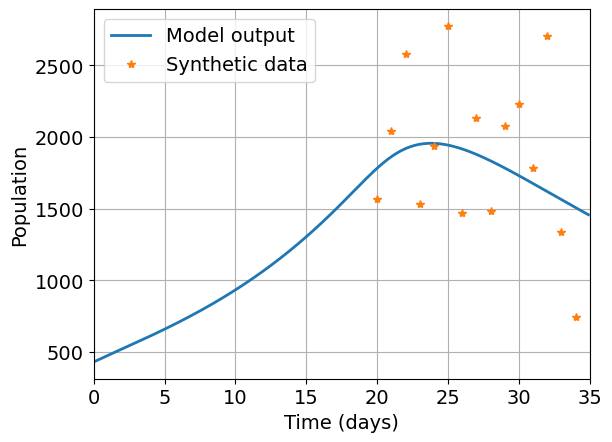

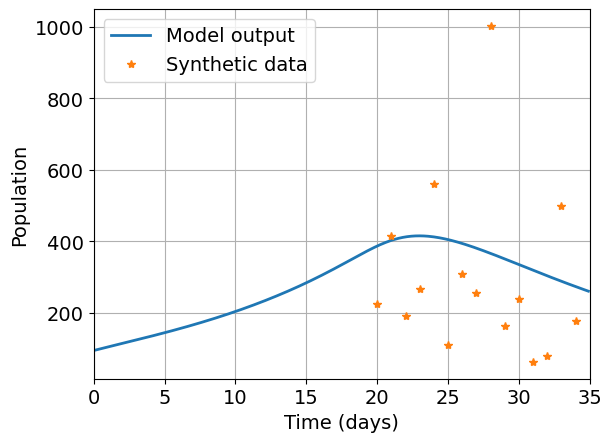

In [8]:
##### LOAD PRE GENERATED NOISY DATA #########

### Synthetic data - true solution
file = np.genfromtxt('./coupled_TD_synthetic_data.csv', delimiter=',')
# file = np.loadtxt('./coupled_TD_synthetic_data.csv')
I_synthetic = file[tstart:tlim]


idxmoh = 0

#### With mobility tensor   

for kk in range(1,len(tmoh)):


    for gg in range(0,N_city):

        L_sum = 0
        for ll in range(0,N_city):

            Nlm = 0
            L_cityinf = 0
            
            for mm in range(0,N_city):
                Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]


                L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])



            L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


        L_Force[kk-1,gg] = L_sum


        S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
        E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
        I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
        R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
        D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
        N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


        if( kk%ndiv == 0):
            idxmoh = int(kk/ndiv)
            if(tstart != 0):
                if(idxmoh >= tstart and idxmoh < tlim):
                    I_model[idxmoh-tstart,gg] = I[kk,gg]
            else:
                idxmoh = int(kk/ndiv)
                I_model[idxmoh,gg] = I[kk,gg]



for hh in range(N_city):
    plt.plot(tmoh, I[:,hh], '-',linewidth=2, label='Model output')
    plt.plot(t, I_synthetic[:,hh], '*', markersize=6, label='Synthetic data')
    plt.legend(loc='best')
    plt.xlabel('Time (days)')
    plt.xlim([0,tlim])
    plt.ylabel('Population')
    plt.grid()
    # plt.savefig(filepath)
    plt.show()




### Computing the log likelihood for coupled PHUs 

In [9]:


##### CHNAGE HERE - ACCORDING TO THE SIGN OF THE PARAMETERS
param1 = np.linspace(-0.5,0.1,100)  # a0
param2 = np.linspace(-0.5,0.1,100) # a1


L = np.zeros([len(param1),len(param2)])

Lhsum = np.zeros([len(param1),len(param2)])

#### CHANGE HERE 
p = 0.005 # probability of success

for p1 in range(len(param1)):
    
    for p2 in range(len(param2)):

        Lprod = 1
        loglik = 0

        #### CHANGE HERE ########
        beta_i[:,0] = a01 + param1[p1]/(1 + np.exp((t11-tmoh))) 
    
        beta_i[:,1] = a02 + param2[p2]/(1 + np.exp((t12-tmoh)))  
    
        beta_e[:,0] = beta_i[:,0]
        beta_e[:,1] = beta_i[:,1]

#### With mobility tensor   

        for kk in range(1,len(tmoh)):

            for gg in range(0,N_city):

                L_sum = 0
                for ll in range(0,N_city):

                    Nlm = 0
                    L_cityinf = 0
                    
                    for mm in range(0,N_city):
                        Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]


                        L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


                    L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


                L_Force[kk-1,gg] = L_sum


                S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
                E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
                I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
                R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
                D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
                N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]

                ## For collecting the model output only at data points

                if( kk%ndiv == 0):
                    
                    idxmoh = int(kk/ndiv)

                    if(tstart !=0):
                        if(idxmoh >=tstart and idxmoh<tlim):

                            logNfac = 0.0

                            if int(I_synthetic[idxmoh-tstart,gg]) != 0:
                                logNfac = np.sum(np.log(np.arange(0,int(I_synthetic[idxmoh-tstart, gg]),1)+1)) #log factorial

                            r = (p*I[kk,gg])/(1-p)
                            # print(r)
                            loglik = loglik + (math.lgamma(I_synthetic[idxmoh-tstart,gg]+r) - (logNfac + math.lgamma(r)) + r*np.log(p) + I_synthetic[idxmoh-tstart,gg]*np.log(1-p))


                    else:

                        logNfac = 0.0

                        if int(I_synthetic[idxmoh,gg]) != 0:
                            logNfac = np.sum(np.log(np.arange(0,int(I_synthetic[idxmoh, gg]),1)+1)) #log factorial

                        r = (p*I[kk,gg])/(1-p)
                        # print(r)
                        loglik = loglik + (math.lgamma(I_synthetic[idxmoh,gg]+r) - (logNfac + math.lgamma(r)) + r*np.log(p) + I_synthetic[idxmoh,gg]*np.log(1-p))


        L[p1,p2] = loglik



In [12]:


ind = np.unravel_index(np.argmax(L, axis=None), L.shape)

print(ind[0])
print(ind[1])

param_mle = np.zeros((2))

param_mle[0] = param1[ind[0]]

param_mle[1] = param2[ind[1]]

print(param_mle[0])
print(param_mle[1])
 
print("max values is", L[ind[0],ind[1]])



fig = plt.figure(2, figsize=(7,5))
ax = fig.gca()
X, Y = np.meshgrid(param1,param2)
# print(np.shape(X))
# print(np.shape(Y))
# print(np.shape(L))
Lt = np.transpose(L)
#### CHANGE HERE VMIN, FOR YOUR CASE 
plt.pcolormesh(X,Y,Lt,vmin=-250)
plt.xlabel('$a_{1}^{1}$')
plt.ylabel('$a_{1}^{2}$')


### CHANGE HERE
ax.scatter(a11,a12,color='black', label=f'Truth = {para[0], para[1]}')
ax.scatter(param1[ind[0]],param2[ind[1]],color='red', label=f'MLE = ({param1[ind[0]]:.3f}, {param2[ind[1]]:.3f})')

plt.colorbar()
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figs/LL_synthetic_a11_a12',bbox_inches='tight')
plt.show()



%matplotlib
from mpl_toolkits import mplot3d

fig = plt.figure(4,figsize=(7,5))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Lt, 100, cmap='binary')

ax.contour3D(X, Y, Lt, 100, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('$a_{1}^{1}$', labelpad=10)
ax.set_ylabel('$a_{1}^{2}$', labelpad=10)
ax.set_zlabel('log likelihood', labelpad=15)
plt.tight_layout()
# plt.savefig('./figs/LL_synthetic_a11_a12_3d', bbox_inches='tight')
fig.show()

# np.savetxt('./Lt.dat',Lt)

67
61
-0.09393939393939393
-0.1303030303030303
max values is -214.06081516292377
Using matplotlib backend: MacOSX


/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_42325/2548938543.py:51: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'edgecolor'
  ax.contour3D(X, Y, Lt, 100, rstride=1, cstride=1,


#### Using MLE values to predict infections

In [15]:


beta_i[:,0] = a01  + param_mle[0]/(1 + np.exp((t11-tmoh))) 
    
beta_i[:,1] = a02 + param_mle[1]/(1 + np.exp((t12-tmoh))) 
    
beta_e[:,0] = beta_i[:,0]
beta_e[:,1] = beta_i[:,1]



idxmoh = 0

#### With mobility tensor   

for kk in range(1,len(tmoh)):

    for gg in range(0,N_city):

        L_sum = 0
        for ll in range(0,N_city):

            Nlm = 0
            L_cityinf = 0
            
            for mm in range(0,N_city):
                Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                L_cityinf = L_cityinf + (beta_e[kk-1,mm] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,mm] * M[2,mm,ll,kk-1] * I[kk-1,mm])


            L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


        L_Force[kk-1,gg] = L_sum


        S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
        E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
        I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
        R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
        D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
        N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


        
for jj in range(N_city):
    plt.figure(figsize=(7,5))
    plt.plot(t, I_model[:,jj], 'go', markersize=6, label=f'Original model output-{jj+1}')
    plt.plot(tmoh, I[:,jj], '-',linewidth=2, label=f'MLE fit-{jj+1}')
    plt.legend(loc='best')
    plt.xlabel('Time (days)')
    plt.xlim([0,tlim])
    plt.ylabel('Infected cases')
    plt.grid()
    # plt.savefig('./figs/predictions_a02_a12')
    plt.show()
